Task 1 - Total energy supplied: 471.46 kWh
Task 2 - Average pump efficiency: 71.85 %
Task 3 - Unused energy: 132.71 kWh


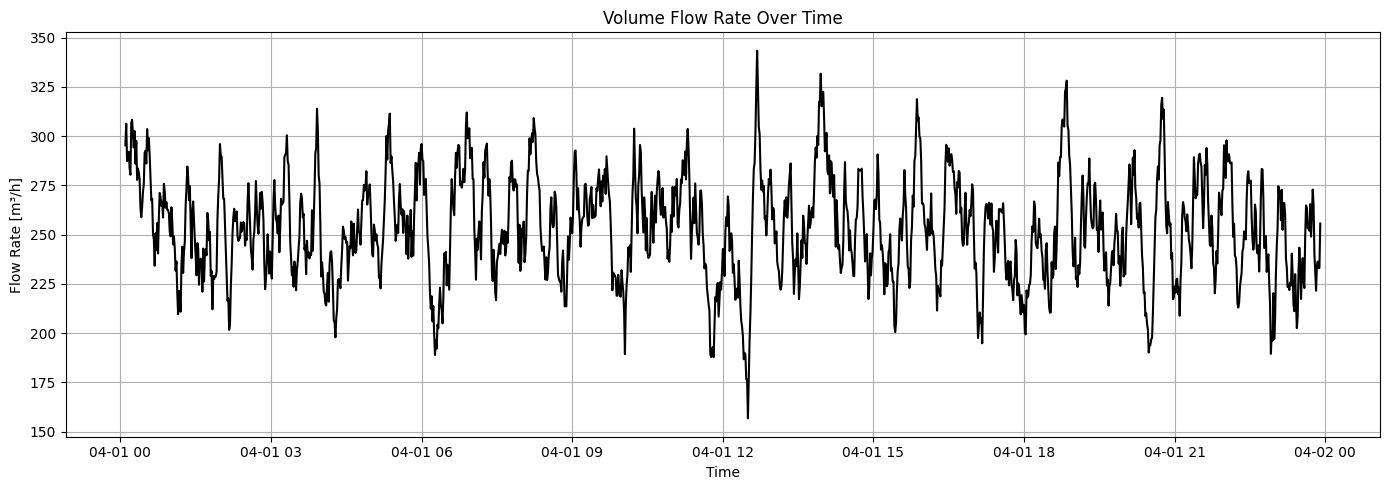

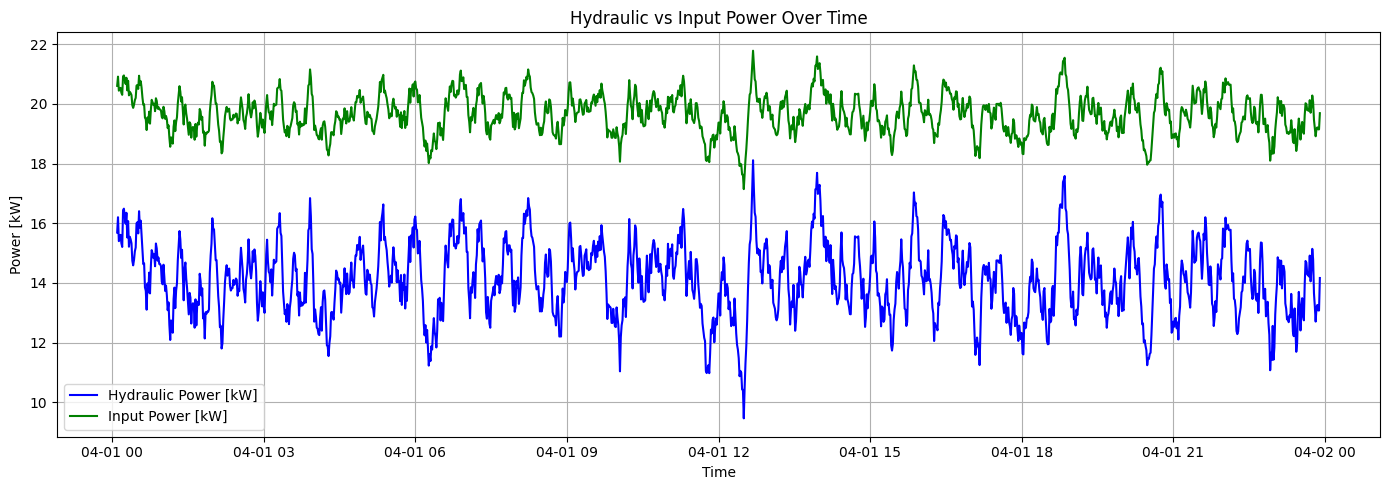

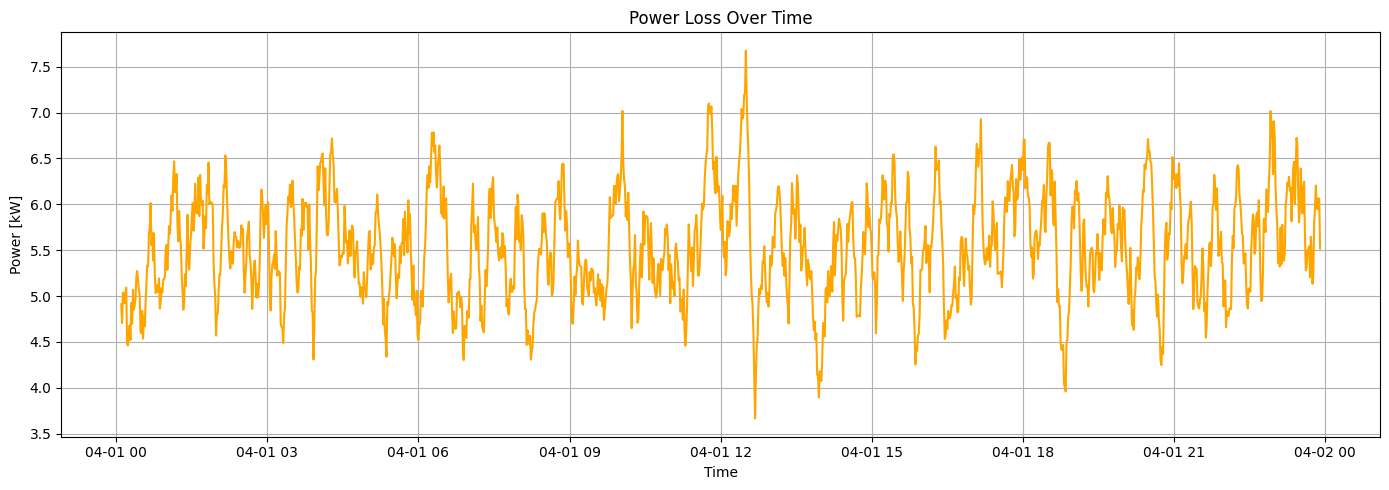

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np

# Data import and conversion
filename = 'volume_flow_data.csv'

df = pd.read_csv(filename, sep=',')

datasheet = pd.read_excel("datenblatt.xls")

df.columns = ['timestamp', 'flow_rate_m3h']

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

df['flow_rate_m3s'] = df['flow_rate_m3h'] / 3600

df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
df = df.dropna().reset_index(drop=True)

rho = 969
g = 9.81

# Interpolation head
head_interpolator = interp1d(datasheet["Q"], datasheet["Foerderhoehe"], bounds_error=False, fill_value="extrapolate")
df['head_m'] = head_interpolator(df['flow_rate_m3h'])


# --> Task 1: Calculation energy consumption
# This task calculates the electrical energy consumed by the pump system.
# First, hydraulic power is computed using flow rate and head.
# Then, electrical input power is estimated by interpolating manufacturer data.
# Energy for each time interval is calculated from the input power.
# Finally, the total energy input is summed and converted to kWh.

df['hydraulic_power_W'] = rho * g * df['flow_rate_m3s'] * df['head_m']

input_power_interpolator = interp1d(datasheet["Q"], datasheet["Leistungsbedarf"], bounds_error=False, fill_value="extrapolate")
df['input_power_W'] = input_power_interpolator(df['flow_rate_m3h']) * 1000

df['energy_input_Wh'] = df['input_power_W'] * df['time_diff'] / 3600
total_energy_input_kWh = df['energy_input_Wh'].sum() / 1000

print(f"Task 1 - Total energy supplied: {total_energy_input_kWh:.2f} kWh")


# --> Task 2: Average efficiency
# This task calculates the average efficiency of the pump.
# First, the hydraulic energy output is computed using hydraulic power over time.
# The total hydraulic energy is then summed and converted to kWh.
# Efficiency is calculated as the ratio of hydraulic energy to input energy, in percent.

df['energy_hydraulic_Wh'] = df['hydraulic_power_W'] * df['time_diff'] / 3600
total_energy_hydraulic_kWh = df['energy_hydraulic_Wh'].sum() / 1000
pump_efficiency = (total_energy_hydraulic_kWh / total_energy_input_kWh) * 100

print(f"Task 2 - Average pump efficiency: {pump_efficiency:.2f} %")


# --> Task 3: Calculation unused energy
# This task calculates the unused energy.
# It subtracts the total hydraulic energy from the total input energy.
# The result shows how much energy was lost or not converted into hydraulic work.

energy_unused_kWh = total_energy_input_kWh - total_energy_hydraulic_kWh
print(f"Task 3 - Unused energy: {energy_unused_kWh:.2f} kWh")


# --> Task 4: Plotting
# This task prepares data for plotting.
# It converts input and hydraulic power from watts to kilowatts and calculates power loss.
# Then, it creates a new DataFrame with selected columns.
# A rolling average (window=11) is applied to smooth the data before plotting.

df['input_power_kW'] = df['input_power_W'] / 1000
df['hydraulic_power_kW'] = df['hydraulic_power_W'] / 1000
df['loss_power_kW'] = df['input_power_kW'] - df['hydraulic_power_kW']

df_averaged = df[['timestamp', 'flow_rate_m3h', 'hydraulic_power_kW', 'input_power_kW', 'loss_power_kW']].copy()
df_averaged[['flow_rate_m3h', 'hydraulic_power_kW', 'input_power_kW', 'loss_power_kW']] = df_averaged[['flow_rate_m3h', 'hydraulic_power_kW', 'input_power_kW', 'loss_power_kW']].rolling(window=11, center=True).mean()

# Plot 1: Volume flow
plt.figure(figsize=(14, 5))
plt.plot(df_averaged['timestamp'], df_averaged['flow_rate_m3h'], color='black', linewidth=1.5)
plt.title('Volume Flow Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Flow Rate [m³/h]')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Hydraulic power vs. input power
plt.figure(figsize=(14, 5))
plt.plot(df_averaged['timestamp'], df_averaged['hydraulic_power_kW'], label='Hydraulic Power [kW]', color='blue', linewidth=1.5)
plt.plot(df_averaged['timestamp'], df_averaged['input_power_kW'], label='Input Power [kW]', color='green', linewidth=1.5)
plt.title('Hydraulic vs Input Power Over Time')
plt.xlabel('Time')
plt.ylabel('Power [kW]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Power loss
plt.figure(figsize=(14, 5))
plt.plot(df_averaged['timestamp'], df_averaged['loss_power_kW'], color='orange', linewidth=1.5)
plt.title('Power Loss Over Time')
plt.xlabel('Time')
plt.ylabel('Power [kW]')
plt.grid(True)
plt.tight_layout()
plt.show()


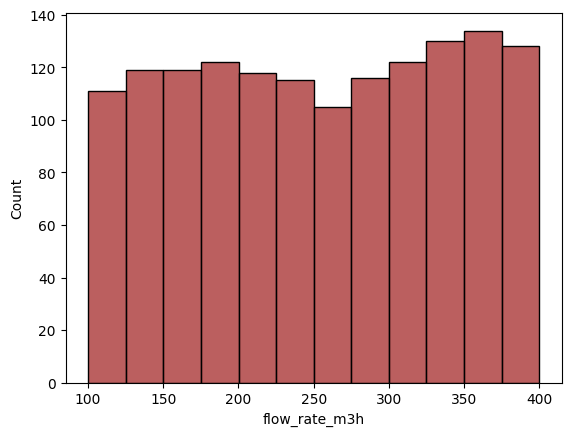

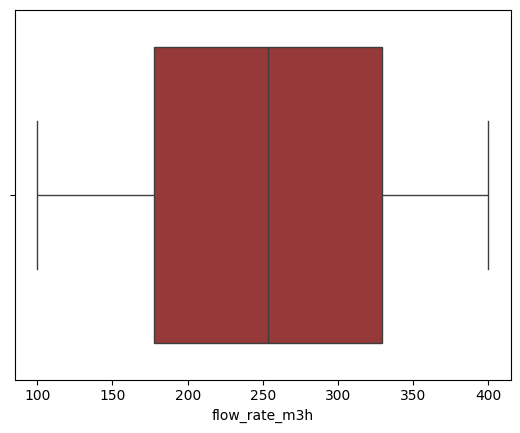

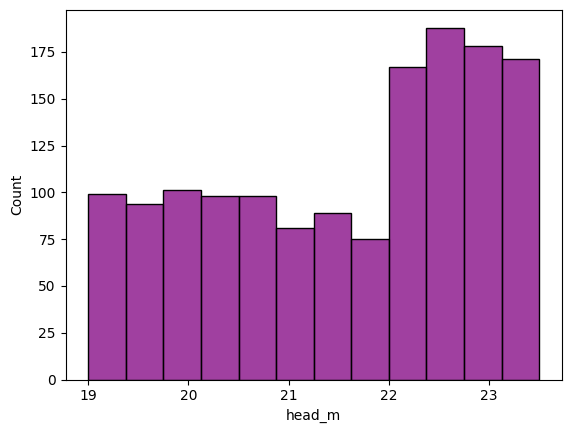

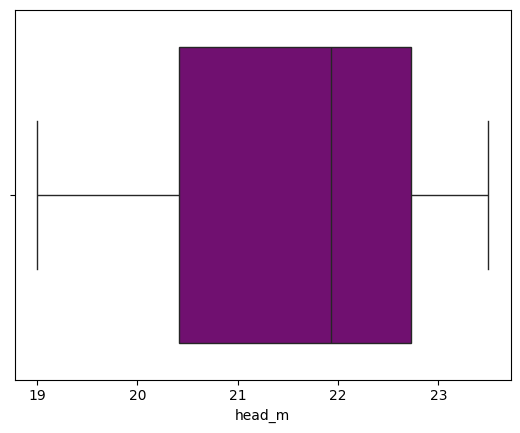

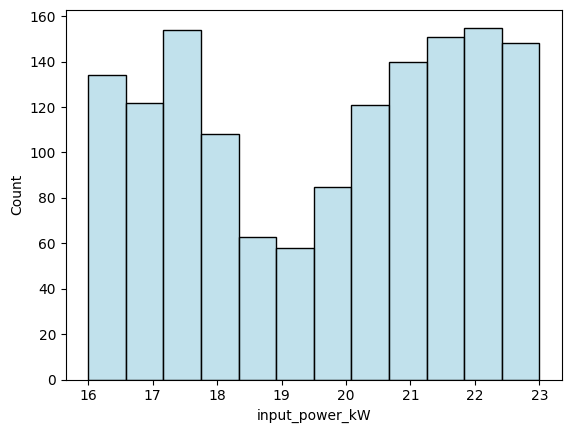

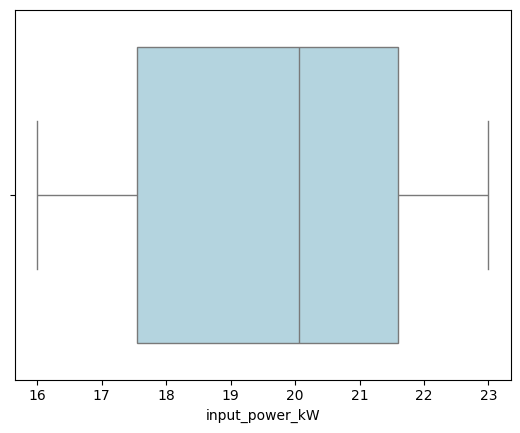

In [3]:
# Histograms of operating behavior
# This part creates histograms and boxplots for the variables “flow_rate_m3h”, “head_m” and “input_power_kW”,
# to visualize their distribution and outliers.
# Each graph is displayed individually.

import seaborn as sns

sns.histplot(df, x="flow_rate_m3h", color='brown')
plt.show()

sns.boxplot(df, x="flow_rate_m3h", color='brown')
plt.show()

sns.histplot(df, x="head_m", color='purple')
plt.show()

sns.boxplot(df, x="head_m", color='purple')
plt.show()

sns.histplot(df, x="input_power_kW", color='lightblue')
plt.show()

sns.boxplot(df, x="input_power_kW", color='lightblue')
plt.show()
